<a href="https://colab.research.google.com/github/likeaAI/ai_study/blob/main/color_cnnmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from glob import glob
from tensorflow.keras.datasets   import boston_housing , mnist , fashion_mnist
from tensorflow.keras.models     import Sequential , clone_model , Model , load_model
from tensorflow.keras.layers     import Dense , Activation , InputLayer , Flatten , Input , BatchNormalization , Dropout , Embedding

# CNN
from tensorflow.keras.layers     import Conv2D , MaxPooling2D , AveragePooling2D
from tensorflow import keras
from tensorflow.keras            import optimizers  
from tensorflow.keras.callbacks  import EarlyStopping , ModelCheckpoint , Callback
from tensorflow.keras.optimizers import SGD , Adam , RMSprop

# 이미지 로드
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# 자연어 처리
from tensorflow.keras.preprocessing.text          import Tokenizer
from tensorflow.keras.preprocessing.sequence      import pad_sequences

from keras.utils.np_utils      import to_categorical

from sklearn.datasets          import load_iris , load_breast_cancer , load_digits
from sklearn.model_selection   import train_test_split

import matplotlib.pyplot as plt

import tensorflow as tf
import numpy  as np
import pandas as pd

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="V1xrnYqaT6VW3skv3nh8")
project = rf.workspace("example01").project("color1")
dataset = project.version(1).download("folder")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 13.8 MB/s 
     |████████████████████████████████| 178 kB 58.7 MB/s 
     |████████████████████████████████| 1.1 MB 61.3 MB/s 
     |████████████████████████████████| 67 kB 6.6 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 138 kB 78.2 MB/s 
     |████████████████████████████████| 596 kB 58.1 MB/s 
     |████████████████████████████████| 62 kB 1.9 MB/s 
  Created wheel for roboflow: filename=roboflow-0.2.4-py3-none-any.whl size=21356 sha256=82a9c7d514523646d5d93e02c07184569ca0774c6ed3c9e2344f659af26a5e36
  Stored in directory: /root/.cache/pip/wheels/b7/2c/60/3733c0e323b1d7aec00f852264314bf6c48192c8e1dc92b3ee
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=5c7541f433fefbb85c98bb04cbe2e39a8535864b7a31151fb38caf1e19f8978e
  Stored in directory: /root/.cache/pip

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to color1-1 in folder:: 100%|██████████| 5070/5070 [00:05<00:00, 913.46it/s]


In [ ]:
train_img_generator = ImageDataGenerator(rescale=1./255)
train_generator = train_img_generator.flow_from_directory(
    '/content/color1-1/train', 
    target_size = (200, 200) , 
    batch_size  = 256,
    class_mode = 'categorical'
)

Found 4869 images belonging to 8 classes.


In [ ]:
test_img_generator = ImageDataGenerator(rescale=1./255)
test_generator = test_img_generator.flow_from_directory(
    '/content/color1-1/valid' , 
    target_size = (200, 200) , 
    batch_size  = 256 ,
    class_mode = 'categorical'
)

Found 181 images belonging to 8 classes.


In [ ]:
def img_model() :
  img_model = Sequential()

  img_model.add( Conv2D(input_shape = (200, 200, 3) , filters = 16 , kernel_size = (3,3) , strides = (1,1) , padding = 'valid') )
  img_model.add( Activation('relu'))
  img_model.add( MaxPooling2D(pool_size = (2,2) , padding = 'valid' ) )
  img_model.add( Dropout(0.25) )
      
  img_model.add( Conv2D(filters = 32 , kernel_size = (3,3) , strides = (1,1) , padding = 'valid') )
  img_model.add( Activation('relu'))
  img_model.add( MaxPooling2D(pool_size = (2,2) , padding = 'valid' ) )
  img_model.add( Dropout(0.25) )

  img_model.add( Conv2D(filters = 64 , kernel_size = (3,3) , strides = (1,1) , padding = 'valid') )
  img_model.add( Activation('relu'))
  img_model.add( MaxPooling2D(pool_size = (2,2) , padding = 'valid' ) )
  img_model.add( Dropout(0.25) )

  img_model.add( Conv2D(filters = 64 , kernel_size = (3,3) , strides = (1,1) , padding = 'valid') )
  img_model.add( Activation('relu'))
  img_model.add( MaxPooling2D(pool_size = (2,2) , padding = 'valid' ) )
  img_model.add( Dropout(0.25) )
    

  img_model.add( Flatten() )
  img_model.add( Dense(units = 128) )  # 512->1024
  img_model.add( Activation('relu') )
  img_model.add( Dropout(0.25) )
    
  
  img_model.add( Dense(units = 8) )
  img_model.add( Activation('softmax') )

  return img_model 

In [ ]:
model = img_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 198, 198, 16)      448       
                                                                 
 activation_12 (Activation)  (None, 198, 198, 16)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 99, 99, 16)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 99, 99, 16)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 activation_13 (Activation)  (None, 97, 97, 32)        0         
                                                      

In [ ]:
model.compile(optimizer = Adam(lr = 0.001), 
                      loss= 'categorical_crossentropy' , 
                      metrics=['accuracy']
             ) 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
cb = keras.callbacks.ModelCheckpoint('color.h5')
es = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

In [ ]:
model_history = model.fit(train_generator, validation_data=test_generator,epochs=100 ,verbose=1 ,callbacks=[es,cb]) 

Epoch 1/100
20/20 [==============================] - 19s 899ms/step - loss: 1.8021 - accuracy: 0.3128 - val_loss: 1.5197 - val_accuracy: 0.5249
Epoch 2/100
20/20 [==============================] - 17s 867ms/step - loss: 1.1894 - accuracy: 0.5451 - val_loss: 1.0783 - val_accuracy: 0.6630
Epoch 3/100
20/20 [==============================] - 17s 859ms/step - loss: 0.9585 - accuracy: 0.6525 - val_loss: 0.9281 - val_accuracy: 0.7569
Epoch 4/100
20/20 [==============================] - 18s 872ms/step - loss: 0.7341 - accuracy: 0.7400 - val_loss: 0.7439 - val_accuracy: 0.8066
Epoch 5/100
20/20 [==============================] - 18s 872ms/step - loss: 0.7265 - accuracy: 0.7468 - val_loss: 0.7725 - val_accuracy: 0.7845
Epoch 6/100
20/20 [==============================] - 18s 883ms/step - loss: 0.5899 - accuracy: 0.7959 - val_loss: 0.6380 - val_accuracy: 0.7901
Epoch 7/100
20/20 [==============================] - 18s 874ms/step - loss: 0.6110 - accuracy: 0.7846 - val_loss: 0.6305 - val_accuracy:

In [ ]:
print('모델 저장')
model.save('color')


모델 저장
INFO:tensorflow:Assets written to: color/assets


In [ ]:
# # Converting a SavedModel to a TensorFlow Lite model.
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# #저장
# open('color_model.tflite', 'wb').write(tflite_model)

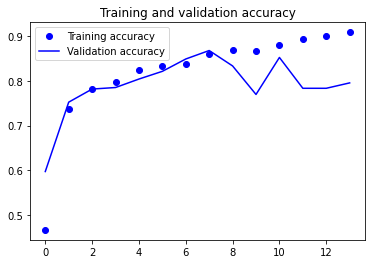

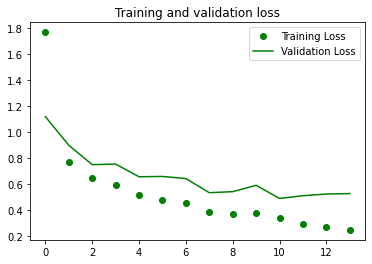

In [ ]:
import matplotlib.pyplot as plt

acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
train_generator.class_indices

{'beige': 0,
 'black': 1,
 'blue': 2,
 'gray': 3,
 'green': 4,
 'pattren': 5,
 'red': 6,
 'white': 7}

In [ ]:
# '/content/cloths_color-4/valid/red/red58_jpg.rf.fd3b092f540c2495f760323b62029e05.jpg'

def image_upload (image_upload) : 
  color = {'black': 0, 'blue': 1, 'green': 2, 'pattern': 3, 'red': 4, 'white': 5}
  img_src = image_upload
  test_img = image.load_img(img_src, target_size=(200, 200))
  x = image.img_to_array(test_img)
  x = np.expand_dims(x, axis = 0)
  image_ = np.vstack([x])
  classes = model.predict(image_, batch_size = 10)
  print('pred - ', classes[0])
  print(np.argmax(classes[0]))  

In [ ]:
image_upload('/content/test22222222.JPG')

pred -  [0.0000000e+00 1.0000000e+00 0.0000000e+00 5.3428144e-19 0.0000000e+00
 0.0000000e+00]
1


In [ ]:
image_upload('/content/test21.jpg')

pred -  [0. 0. 0. 0. 1. 0.]
4


In [ ]:
image_upload('/content/test333.jpg')

pred -  [0. 0. 1. 0. 0. 0.]
2


In [ ]:
image_upload('/content/2.jpg')

pred -  [0.000000e+00 0.000000e+00 0.000000e+00 9.994135e-01 0.000000e+00
 5.864738e-04]
3


In [ ]:
image_upload('/content/5.jpg')

pred -  [0. 1. 0. 0. 0. 0.]
1
